In [94]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.constants import Boltzmann
from tqdm import tqdm

### Initialization

(100, 3)


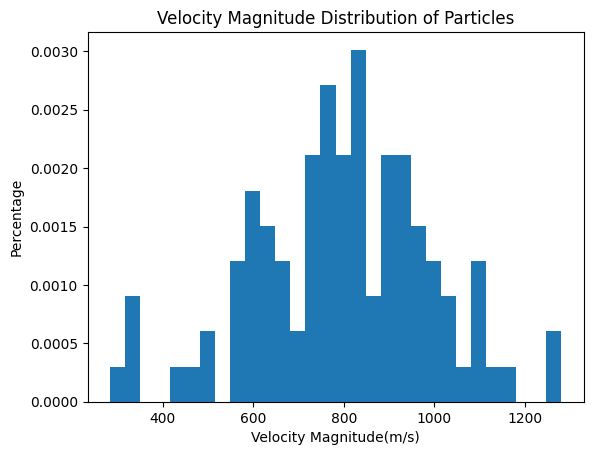

In [104]:
# Define the side length of the cubic space
length = 100

# Create a 3D numpy array to represent the cubic space
cubic_space = np.zeros((length, length, length))

# Create the lattice within the cubic space
lattice_height = length // 4
cubic_space[:, :, :lattice_height] = 1  # Assign a value of 1 to represent the lattice

particle_initial_permit = 2*lattice_height  # The initial permit of the particles
# Initialize the free particles within the cubic space
num_particles = 100  # Number of free particles
free_space = cubic_space[:, :, particle_initial_permit:]  # The space above the lattice
# free_space = cubic_space[:, :, lattice_height:]
free_space_indices = np.argwhere(free_space == 0)  # Indices of the free space
selected_indices = np.random.choice(len(free_space_indices), num_particles, replace=False)  # Randomly select indices for the free particles
free_particles_positions = free_space_indices[selected_indices]  # Get the positions of the free particles
cubic_space[free_particles_positions[:, 0], free_particles_positions[:, 1], free_particles_positions[:, 2] + particle_initial_permit] = 2  # Assign a value of 2 to represent the free particles
# cubic_space[free_particles_positions[:, 0], free_particles_positions[:, 1], free_particles_positions[:, 2] + lattice_height] = 2
#=======================================================================================================================
#the position of particle is always x,y,z+particle_initial_permit
#randomly initialize velocity of the particles in 3d a given range of values selected using temperature
q = 2*1.6e-19  # Charge of the particles (He2+ atoms)
temperature = 300  # Temperature in Kelvin
mass = 4*1.6e-27  # Mass of the particles in kg
velocity_range = np.sqrt(3*Boltzmann*temperature/mass)/1.732  # The range of velocity values in each direction
num_particles = len(free_particles_positions)  # Number of free particles
velocities = np.random.uniform(-velocity_range, velocity_range, (num_particles, 3))  # Randomly initialize the velocities of the particles
print(velocities.shape)
#visualize the particles velocity distribution
# Calculate the norm of each velocity vector
velocity_magnitudes = np.linalg.norm(velocities, axis=1)

# Create a histogram of the velocity magnitudes
plt.hist(velocity_magnitudes, bins=30, density=True)

# Set labels and title
plt.xlabel('Velocity Magnitude(m/s)')
plt.ylabel('Percentage')
plt.title('Velocity Magnitude Distribution of Particles')

# Show the plot
plt.show()

In [97]:
k = 1.380649e-23  # Boltzmann constant in J/K
T = 300  #Kelvin
v_avg = np.sqrt((8 * k * T) / (np.pi * mass))
v=np.array([v_avg/1.732,v_avg/1.732,v_avg/1.732])
print(v)

[741.19836249 741.19836249 741.19836249]


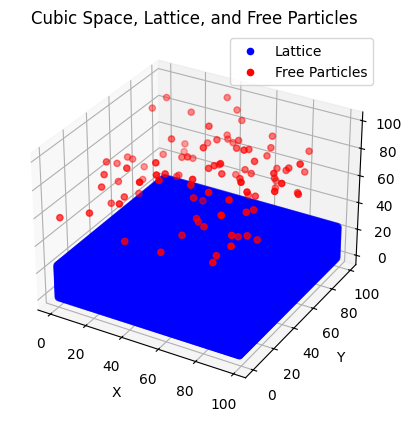

In [98]:
# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the x, y, and z coordinates of the lattice and free particles
lattice_x, lattice_y, lattice_z = np.where(cubic_space == 1)
free_particles_x, free_particles_y, free_particles_z = np.where(cubic_space == 2)

# Plot the lattice and free particles
ax.scatter(lattice_x, lattice_y, lattice_z, color='blue', label='Lattice')
ax.scatter(free_particles_x, free_particles_y, free_particles_z, color='red', label='Free Particles')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Cubic Space, Lattice, and Free Particles')
ax.legend()

# Show the plot
plt.show()

### Defining Interactions and dynamics

In [99]:
size = len(free_particles_positions)
charges = np.full(size, q)
masses = np.full(size, mass)

#define electric and magnetic field vectors
# Define the electric field vector
E = np.array([0, 0, -1])

# Define the magnetic field vector
M = np.array([0, 0, 0])

In [100]:
def calculate_forces(particles, velocities, charges, epsilon, sigma, E, B):
    """
    Calculates the forces on the particles due to the electric field, magnetic field, and Lennard-Jones interactions.
    particles: positions of the particles
    velocities: velocities of the particles
    charges: charges of the particles
    epsilon: depth of the potential well in the Lennard-Jones potential
    sigma: distance at which the potential is zero in the Lennard-Jones potential
    E: electric field
    B: magnetic field
    """
    # Initialize forces as float
    forces = charges[:, np.newaxis] * E.astype(float)

    # Add forces due to Lennard-Jones interactions
    for i in range(len(particles)):
        for j in range(i+1, len(particles)):
            r = particles[j] - particles[i]
            r_norm = np.linalg.norm(r)
            F = 24 * epsilon * ((2 * (sigma / r_norm)**12) - (sigma / r_norm)**6) * (r / r_norm)
            forces[i] += F
            forces[j] -= F

    # Add forces due to magnetic field
    forces += charges[:, np.newaxis] * np.cross(velocities, B)

    return forces

def velocity_verlet(particles, velocities, charges, masses, epsilon, sigma, E, B, dt):
    """
    Implements the Velocity Verlet algorithm to update particle positions and velocities.
    particles: positions of the particles
    velocities: velocities of the particles
    charges: charges of the particles
    masses: masses of the particles
    epsilon: depth of the potential well in the Lennard-Jones potential
    sigma: distance at which the potential is zero in the Lennard-Jones potential
    E: electric field
    B: magnetic field
    dt: time step
    """
    # Calculate forces
    forces = calculate_forces(particles, velocities, charges, epsilon, sigma, E, B)

    # Update positions
    particles = particles + velocities * dt + 0.5 * (forces / masses[:, np.newaxis]) * dt**2

    # Calculate new forces
    new_forces = calculate_forces(particles, velocities, charges, epsilon, sigma, E, B)

    # Update velocities
    velocities = velocities + 0.5 * ((forces + new_forces) / masses[:, np.newaxis]) * dt

    return particles, velocities


In [101]:
# Define the number of iterations for the simulation and the z-coordinate threshold
N = 50
z_threshold = lattice_height

# Initialize counter for the number of particles that reach or go below the z-coordinate threshold
threshold_count = 0
particles = free_particles_positions.copy()
# Run the simulation
for iteration in tqdm(range(N)):
    # Run Velocity Verlet algorithm
    particles, velocities = velocity_verlet(particles, velocities, charges, masses, 1.0, 1.0, E, M, 0.05)

    # Check which particles have reached or gone below the z-coordinate threshold
    below_threshold = particles[:, 2]+particle_initial_permit <= z_threshold
    threshold_count += np.sum(below_threshold)

print("Number of times particles reached or went below the z-coordinate threshold:", threshold_count)

100%|██████████| 50/50 [00:03<00:00, 12.53it/s]

Number of times particles reached or went below the z-coordinate threshold: 2650


### Collision Cascade

In [110]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann

# Define the side length of the cubic space
length = 100

# Create a 3D numpy array to represent the cubic space
cubic_space = np.zeros((length, length, length))

# Create the lattice within the cubic space
lattice_height = length // 4
cubic_space[:lattice_height, :, :] = 1  # Assign a value of 1 to represent the lattice

particle_initial_permit = 2*lattice_height  # The initial permit of the particles
# Initialize the free particles within the cubic space
num_particles = 100  # Number of free particles
free_space = cubic_space[particle_initial_permit:, :, :]  # The space above the lattice
free_space_indices = np.argwhere(free_space == 0)  # Indices of the free space
selected_indices = np.random.choice(len(free_space_indices), num_particles, replace=False)  # Randomly select indices for the free particles
free_particles_positions = free_space_indices[selected_indices] + np.array([particle_initial_permit, 0, 0])  # Get the positions of the free particles
cubic_space[free_particles_positions[:, 0], free_particles_positions[:, 1], free_particles_positions[:, 2]] = 2  # Assign a value of 2 to represent the free particles

# Define the charge and mass of the particles
q = 2*1.6e-19  # Charge of the particles (He2+ atoms)
mass = 4*1.6e-27  # Mass of the particles in kg

# Define the temperature and velocity range of the particles
temperature = 300  # Temperature in Kelvin
velocity_range = np.sqrt(3*Boltzmann*temperature/mass)/1.732  # The range of velocity values in each direction

# Initialize the velocities of the particles
velocities = np.random.uniform(-velocity_range, velocity_range, (num_particles, 3))  # Randomly initialize the velocities of the particles

# Define the maximum energy for a binary collision
max_binary_collision_energy = 10*q**2/(4*np.pi*8.84*10e-12*1e-10)  # The maximum energy for a binary collision in eV

# Define the time step and total simulation time
time_step = 1e-15  # Time step in seconds
total_time = 1e-12  # Total simulation time in seconds

# Define the function for calculating the distance between two particles
def distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

# Define the function for calculating the energy of a binary collision
def binary_collision_energy(v1, v2, m1, m2):
    v_rel = v1 - v2
    v_cm = (m1*v1 + m2*v2)/(m1 + m2)
    v_rel_cm = v_rel - v_cm
    kinetic_energy = 0.5*m1*v1**2 + 0.5*m2*v2**2
    kinetic_energy_rel_cm = 0.5*(m1 + m2)*v_rel_cm**2
    return kinetic_energy - kinetic_energy_rel_cm

# Define the function for checking if a particle has collided with the lattice
def check_lattice_collision(p, v):
    if p[0] < lattice_height and cubic_space[p[0], p[1], p[2]] == 1:
        return True
    return False

# Define the function for checking if a binary collision has occurred
def check_binary_collision(p1, p2, v1, v2):
    energy = binary_collision_energy(v1, v2, mass, mass)
    if energy.any() > max_binary_collision_energy:
        return True
    return False

# Define the function for updating the positions of the particles
def update_positions(p, v, time_step):
    return p + v*time_step

# Define the function for updating the velocities of the particles after a binary collision
def update_velocities(v1, v2, m1, m2):
    v_rel = v1 - v2
    v_cm = (m1*v1 + m2*v2)/(m1 + m2)
    v_rel_cm = v_rel - v_cm
    m_total = m1 + m2
    v_new_cm = v_cm + (v_rel_cm*(m1+m2)-v_rel*(m1-m2))/(m_total*(m1+m2))
    v1_new = v1 - v_rel + v_rel_cm - v_cm
    v2_new = v2 + v_rel - v_rel_cm + v_cm
    return v1_new, v2_new

# Initialize the list for storing the binary collision information
binary_collision_info = []

# Initialize the counter for the number of binary collisions
num_binary_collisions = 0

# Initialize the counter for the number of lattice collisions
num_lattice_collisions = 0

# Initialize the counter for the number of collisions
num_collisions = 0

# Initialize the counter for the number of collisions between particles and the lattice
num_lattice_collisions = 0

# Initialize the counter for the number of collisions between free particles
num_free_collisions = 0
free_particles_positions = free_particles_positions.astype(float)
# Run the simulation
for t in np.arange(0, total_time, time_step):
    # Update positions
    free_particles_positions += velocities * time_step
    # Ensure particles stay within the cubic space
    free_particles_positions = np.clip(free_particles_positions, 0, length - 1)
    # Convert positions to integers for use as indices
    indices = np.round(free_particles_positions).astype(int)

    for i in range(num_particles):
        p1 = indices[i]
        v1 = velocities[i]
        if cubic_space[tuple(p1)] == 1:
            num_lattice_collisions += 1
            velocities[i] = np.random.uniform(-velocity_range, velocity_range, 3)
        else:
            for j in range(i+1, num_particles):
                p2 = indices[j]
                v2 = velocities[j]
                if np.linalg.norm(p1 - p2) < 2 and binary_collision_energy(v1, v2, mass, mass) > max_binary_collision_energy:
                    num_binary_collisions += 1
                    velocities[i], velocities[j] = update_velocities(v1, v2, mass, mass)
                    velocities[i] = v1_new
                    velocities[j] = v2_new
                    binary_collision_info.append((p1, p2, v1, v2))
                else:
                    p1_new = update_positions(p1, v1, time_step)
                    p2_new = update_positions(p2, v2, time_step)
                    if distance(p1_new, p2_new) < 2:
                        num_free_collisions += 1
                        v1_new, v2_new = update_velocities(v1, v2, mass, mass)
                        velocities[i] = v1_new
                        velocities[j] = v2_new
                        free_particles_positions[i] = p1_new
                        free_particles_positions[j] = p2_new

# Print the results of the simulation
print('Number of binary collisions:', num_binary_collisions)
print('Number of lattice collisions:', num_lattice_collisions)
print('Number of collisions between particles and the lattice:', num_lattice_collisions)
print('Number of collisions between free particles:', num_free_collisions)
print('Number of collisions:', num_collisions)

Number of binary collisions: 0
Number of lattice collisions: 0
Number of collisions between particles and the lattice: 0
Number of collisions between free particles: 0
Number of collisions: 0


Ion Ion potentials

In [112]:
#define electric and magnetic field vectors
# Define the electric field vector
E = np.array([0, 0, 1])

# Define the magnetic field vector
M = np.array([0, 0, 0])

In [113]:
def calculate_forces(particles, velocities, charges, epsilon, sigma, E, B):
    """
    Calculates the forces on the particles due to the electric field, magnetic field, and Lennard-Jones interactions.
    particles: positions of the particles
    velocities: velocities of the particles
    charges: charges of the particles
    epsilon: depth of the potential well in the Lennard-Jones potential
    sigma: distance at which the potential is zero in the Lennard-Jones potential
    E: electric field
    B: magnetic field
    """
    # Initialize forces as float
    forces = charges[:, np.newaxis] * E.astype(float)

    # Add forces due to Lennard-Jones interactions
    for i in range(len(particles)):
        for j in range(i+1, len(particles)):
            r = particles[j] - particles[i]
            r_norm = np.linalg.norm(r)
            F = 24 * epsilon * ((2 * (sigma / r_norm)**12) - (sigma / r_norm)**6) * (r / r_norm)
            forces[i] += F
            forces[j] -= F

    # Add forces due to magnetic field
    forces += charges[:, np.newaxis] * np.cross(velocities, B)

    return forces

def velocity_verlet(particles, velocities, charges, masses, epsilon, sigma, E, B, dt):
    """
    Implements the Velocity Verlet algorithm to update particle positions and velocities.
    particles: positions of the particles
    velocities: velocities of the particles
    charges: charges of the particles
    masses: masses of the particles
    epsilon: depth of the potential well in the Lennard-Jones potential
    sigma: distance at which the potential is zero in the Lennard-Jones potential
    E: electric field
    B: magnetic field
    dt: time step
    """
    # Calculate forces
    forces = calculate_forces(particles, velocities, charges, epsilon, sigma, E, B)

    # Update positions
    particles = particles + velocities * dt + 0.5 * (forces / masses[:, np.newaxis]) * dt**2

    # Calculate new forces
    new_forces = calculate_forces(particles, velocities, charges, epsilon, sigma, E, B)

    # Update velocities
    velocities = velocities + 0.5 * ((forces + new_forces) / masses[:, np.newaxis]) * dt

    return particles, velocities


In [114]:
def lennard_jones_potential(r, epsilon, sigma):
    """
    Calculates the Lennard-Jones potential between two particles.
    r: distance between the particles
    epsilon: depth of the potential well
    sigma: distance at which the potential is zero
    """
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

def hamiltonian(particles, velocities, charges, masses, epsilon, sigma, E, B):
    """
    Calculates the Hamiltonian (total energy) of a system of particles.
    particles: positions of the particles
    velocities: velocities of the particles
    charges: charges of the particles
    masses: masses of the particles
    temperature: temperature of the system
    epsilon: depth of the potential well in the Lennard-Jones potential
    sigma: distance at which the potential is zero in the Lennard-Jones potential
    E: electric field
    B: magnetic field
    """
    # Calculate kinetic energy from the magnetic field
    kinetic_energy = 0.5 * np.sum(masses * np.sum(velocities**2, axis=1)) + np.sum(charges * np.cross(velocities, B)**2 / (2 * masses))

    # Calculate potential energy from the electric field and Lennard-Jones interactions
    potential_energy = -np.sum(charges * E * particles)
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            r = np.linalg.norm(particles[i] - particles[j])
            potential_energy += lennard_jones_potential(r, epsilon, sigma)

    return kinetic_energy + potential_energy

In [115]:
def binary_collision_model(particles, velocities, charges, masses, epsilon, sigma, E, B, lattice_boundary, energy_threshold):
    """
    Implements a binary collision model.
    particles: positions of the particles
    velocities: velocities of the particles
    charges: charges of the particles
    masses: masses of the particles
    epsilon: depth of the potential well in the Lennard-Jones potential
    sigma: distance at which the potential is zero in the Lennard-Jones potential
    E: electric field
    B: magnetic field
    lattice_boundary: boundary of the lattice
    energy_threshold: energy threshold for a collision
    """
    Y = 0
    sputtered_particles = []
    sputtered_positions = []
    for i in range(len(particles)):
        # Check if the particle has reached the lattice boundary
        if np.any(particles[i][2]+particle_initial_permit <= lattice_boundary):
            # Calculate the energy of the particle
            particle_energy = hamiltonian(np.array([particles[i]]), np.array([velocities[i]]), np.array([charges[i]]), np.array([masses[i]]), epsilon, sigma, E, B)

            # Check if the energy of the particle is equal to or greater than the energy threshold
            if np.abs(particle_energy) >= energy_threshold:
                # Collision occurs, update the velocity of the particle
                velocities[i] = -velocities[i]
                Y += 1 

                # If the energy exceeds the threshold, the particle is sputtered
                sputtered_particles.append(i)
                sputtered_positions.append(particles[i])

    return particles, velocities, charges, masses, sputtered_particles, sputtered_positions, Y

In [117]:
# Define the number of iterations for the simulation
num_iterations = 1000
epsilon = 1.0
sigma = 1.0
B = M
dt = 0.05
energy_threshold = 0
# Initialize counters for the number of particles that reach the boundary and surpass the energy threshold
boundary_count = 0
threshold_count = 0
particles = free_particles_positions.copy()
# Run the simulation
for iteration in tqdm(range(num_iterations)):
    # Run Velocity Verlet algorithm
    particles, velocities = velocity_verlet(particles, velocities, charges, masses, epsilon, sigma, E, B, dt)

    # Run binary collision model
    particles, velocities, charges, masses, sputtered_particles, sputtered_positions, Y = binary_collision_model(particles, velocities, charges, masses, epsilon, sigma, E, B, lattice_height, energy_threshold)
    # Update counters
    boundary_count += len(sputtered_particles)
    threshold_count += Y

print("Number of particles that reached the boundary:", boundary_count)
print("Number of particles that surpassed the energy threshold:", threshold_count)

  0%|          | 2/1000 [00:00<01:29, 11.20it/s]C:\Users\ANINDIT\AppData\Local\Temp\ipykernel_23496\1177609923.py:20: RuntimeWarning: overflow encountered in scalar power
  F = 24 * epsilon * ((2 * (sigma / r_norm)**12) - (sigma / r_norm)**6) * (r / r_norm)
C:\Users\ANINDIT\AppData\Local\Temp\ipykernel_23496\1177609923.py:20: RuntimeWarning: invalid value encountered in scalar subtract
  F = 24 * epsilon * ((2 * (sigma / r_norm)**12) - (sigma / r_norm)**6) * (r / r_norm)
100%|██████████| 1000/1000 [01:27<00:00, 11.45it/s]

Number of particles that reached the boundary: 119
Number of particles that surpassed the energy threshold: 119
